In [1]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image, ImageDraw
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from sklearn.metrics import precision_recall_curve, auc, jaccard_score
from skimage import color, measure, feature
from skimage.segmentation import find_boundaries
from skimage.measure import label, regionprops
from skimage.filters import sobel
from scipy.ndimage import binary_dilation

In [2]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: Tesla V100-PCIE-32GB , device num:0


### Data preprocessing

In [4]:
class RandomRotateFlipTransform:
    def __call__(self, img, mask):
        angle = random.choice([0, 180])
        rotated_img = transforms.functional.rotate(img, angle)
        rotated_mask = mask.rotate(angle, resample=Image.NEAREST)

        if random.choice([True, False]):
            rotated_img = transforms.functional.vflip(rotated_img)
            rotated_mask = transforms.functional.vflip(rotated_mask)

        return rotated_img, rotated_mask

In [5]:
class CervicalCellDataset(Dataset):
    def __init__(self, images_root, masks_root, transform=None, mask_transform=None, rotate_transform=None):
        self.images_root = images_root
        self.masks_root = masks_root
        self.transform = transform
        self.mask_transform = mask_transform
        self.rotate_transform = rotate_transform
        self.images = []
        self.masks = []
        
        for subdir in sorted(os.listdir(images_root)):
            
            if subdir == '.ipynb_checkpoints' or not os.path.isdir(os.path.join(images_root, subdir)):
                continue
            
            images_subdir_path = os.path.join(images_root, subdir)
            masks_subdir_path = os.path.join(masks_root, subdir)
            
            images_files = [f for f in os.listdir(images_subdir_path) if f.endswith('.jpg')]
            masks_files = [f.replace('.jpg', '.png') for f in images_files]
            
            self.images += [os.path.join(images_subdir_path, f) for f in images_files]
            self.masks += [os.path.join(masks_subdir_path, f) for f in masks_files]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        
        if self.rotate_transform:
            image, mask = self.rotate_transform(image, mask)
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)*255
        
        mask = torch.from_numpy(np.array(mask)).long()
        
        return image, mask

In [6]:
transform = transforms.Compose([
    transforms.Resize((576, 768)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

mask_transform = transforms.Compose([
    transforms.Resize((576, 768), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

rotate_flip_transform = RandomRotateFlipTransform()
dataset = CervicalCellDataset(images_root='../wg4bpm33hj-2/images',
                              masks_root='../wg4bpm33hj-2/masks',
                              transform=transform,
                              mask_transform=mask_transform,
                              rotate_transform=rotate_flip_transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=6)

In [7]:
print("Dataset size:", len(dataset))
print("Train/Val/Test sizes:", train_size, val_size, test_size)

Dataset size: 9339
Train/Val/Test sizes: 6537 933 1869


In [8]:
unique_labels_all_batches = []
for images, masks in val_loader:
    unique_labels = torch.unique(masks)
    unique_labels_all_batches.extend(unique_labels.tolist())

print(f"All unique labels in dataset: {set(unique_labels_all_batches)}")

All unique labels in dataset: {0, 1, 2, 3, 4, 5, 6, 7}


In [9]:
for batch_idx, (img, mask) in enumerate(train_loader):
    print(f'Image:{img.shape}')
    print(f'mask:{mask.shape}')
    print(f'batch_idx:{batch_idx}')
    break

Image:torch.Size([10, 3, 624, 832])
mask:torch.Size([10, 1, 624, 832])
batch_idx:0


### Dataset visualization

In [7]:
def apply_colored_edges_full_overlay(image, mask, opacity=0.7, dilation_iter=2):
    color_map = plt.cm.tab10(np.linspace(0, 1, 8))[1:8] 
    
    if image.ndim == 2 or image.shape[2] == 1:
        image_rgb = np.stack((image,) * 3, axis=-1)
    else:
        image_rgb = image.copy()
    
    white_layer = np.ones_like(image_rgb) * 255
    image_rgb = (image_rgb * (1 - opacity) + white_layer * opacity).astype(np.uint8)

    for label in range(1, 8):
        label_mask = mask == label
        edges = sobel(label_mask) > 0

        edges_dilated = binary_dilation(edges, iterations=dilation_iter)
        
        for i in range(3):
            image_rgb[edges_dilated, i] = color_map[label-1][i] * 255

    return image_rgb

def unnormalize(image, mean, std):
    for i in range(3):
        image[:, :, i] = image[:, :, i] * std[i] + mean[i]
    return np.clip(image, 0, 1)

In [8]:
def visualize_dataset(dataset, num_samples=7):
    num_samples = min(num_samples, len(dataset))
    indices = random.sample(range(len(dataset)), num_samples)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    fig, axs = plt.subplots(3, num_samples, figsize=(18, 6))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        
        image_np = image.permute(1, 2, 0).numpy()
        image_np = unnormalize(image_np, mean, std)
        
        image_np = (image_np * 255).astype(np.uint8)
        mask_np = mask.squeeze().numpy().astype(np.uint8)
        
        image_title = os.path.basename(dataset.images[idx]).split('.')[0]

        # image
        axs[0, i].imshow(image_np)
        axs[0, i].set_title(image_title, fontsize=12)
        axs[0, i].axis('off')

        # mask
        axs[1, i].imshow(mask_np, cmap='gray')
        axs[1, i].axis('off')

        # fusion
        fusion = apply_colored_edges_full_overlay(image_np, mask_np)
        axs[2, i].imshow(fusion)
        axs[2, i].axis('off')

    fig.text(0.001, 0.81, 'Images', va='center', ha='right', fontsize=14)
    fig.text(0.001, 0.48, 'Masks', va='center', ha='right', fontsize=14)
    fig.text(0.001, 0.16, 'Fusions', va='center', ha='right', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('image.png')
    plt.show()

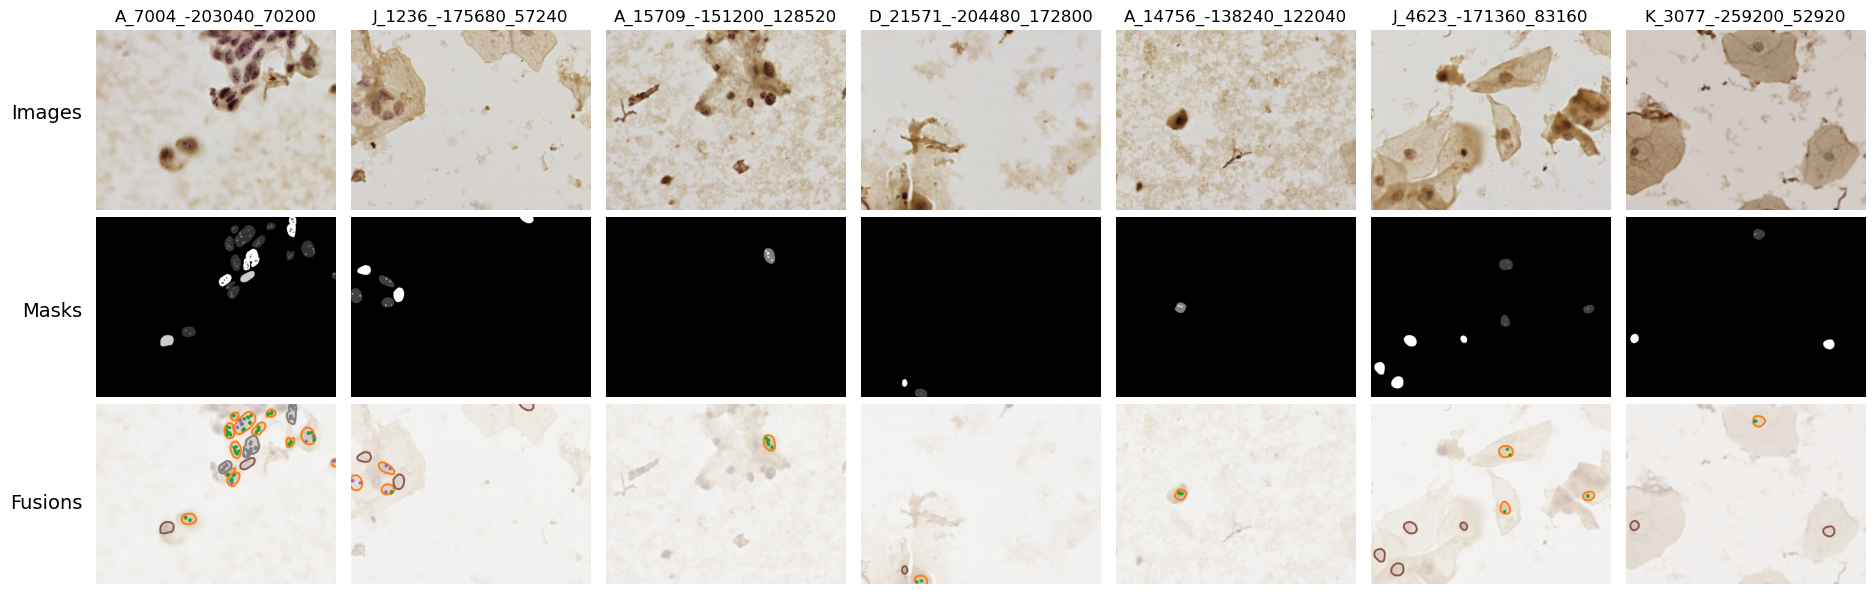

In [16]:
visualize_dataset(dataset, num_samples=7)

### Model

In [9]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.transConv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):

        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class attentionConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(attentionConv, self).__init__()

        self.same_conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.same_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)


    def forward(self, q, k):
        q = self.up(q)
        k = self.same_conv1(k)
        a = q+k
        a = F.relu(a)
        a = self.same_conv2(a)
        a = F.sigmoid(a)
        a = a*k

        return a

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64))
        self.down2 = (Down(64, 128))
        self.down3 = (Down(128, 256))
        factor = 2 if bilinear else 1
        self.up2 = (Up(256, 128 // factor, bilinear))
        self.up3 = (Up(128, 64 // factor, bilinear))
        self.up4 = (Up(64, 32, bilinear))
        self.outc = (OutConv(32, n_classes))

        self.att2 = (attentionConv(256, 128))
        self.att3 = (attentionConv(128, 64))
        self.att4 = (attentionConv(64, 32))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        a4 = self.att2(x4, x3)
        x = self.up2(a4, x3)
        a3 = self.att3(x, x2)
        x = self.up3(a3, x2)
        a2 = self.att4(x, x1)
        x = self.up4(a2, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        
model = UNet(n_channels=3, n_classes=8).to(device)

print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (transConv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, ke

In [17]:
# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=False):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear

#         self.inc = (DoubleConv(n_channels, 32))
#         self.down1 = (Down(32, 64))
#         self.down2 = (Down(64, 128))
#         factor = 2 if bilinear else 1
#         self.down3 = (Down(128, 256 // factor))
#         self.up1 = (Up(256, 128 // factor, bilinear))
#         self.up2 = (Up(128, 64 // factor, bilinear))
#         self.up3 = (Up(64, 32, bilinear))
#         self.outc = (OutConv(32, n_classes))

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x = self.up1(x4, x3)
#         x = self.up2(x, x2)
#         x = self.up3(x, x1)
#         logits = self.outc(x)
#         return logits

#     def use_checkpointing(self):
#         self.inc = torch.utils.checkpoint(self.inc)
#         self.down1 = torch.utils.checkpoint(self.down1)
#         self.down2 = torch.utils.checkpoint(self.down2)
#         self.down3 = torch.utils.checkpoint(self.down3)
#         self.up1 = torch.utils.checkpoint(self.up1)
#         self.up2 = torch.utils.checkpoint(self.up2)
#         self.up3 = torch.utils.checkpoint(self.up3)
#         self.outc = torch.utils.checkpoint(self.outc)

# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""

#     def __init__(self, in_channels, out_channels, mid_channels=None, dropout_prob=0.5):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout_prob),  # 添加 Dropout 層
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)


# class Down(nn.Module):
#     """Downscaling with maxpool then double conv"""

#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool2d(2),
#             DoubleConv(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)


# class Up(nn.Module):
#     """Upscaling then double conv"""

#     def __init__(self, in_channels, out_channels, bilinear=True):
#         super(Up, self).__init__()
#         self.bilinear = bilinear

#         # if bilinear, use the normal convolutions to reduce the number of channels
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
#         else:
#             self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
#             self.conv = DoubleConv(in_channels, out_channels)

#         self.attention = SpatialAttentionModule()

#     def forward(self, x1, x2):
#         x1 = self.up(x1)
        
#         # Apply the spatial attention to the skip connection
#         attention = self.attention(x2)
#         x2 = x2 * attention

#         # input is CHW
#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])
        
#         # for Bilinear interpolation
#         if self.bilinear and x1.size() != x2.size():
#             x1 = F.interpolate(x1, size=(x2.size(2), x2.size(3)), mode='bilinear', align_corners=True)

#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)


# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)


# class SpatialAttentionModule(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttentionModule, self).__init__()
#         self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x = torch.cat([avg_out, max_out], dim=1)
#         x = self.conv1(x)
#         return self.sigmoid(x)
    
# model = UNet(n_channels=3, n_classes=8).to(device)

# print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.5, inplace=False)
          (4

### Visualization of training results

In [10]:
def create_comparison_fusion(true_fusion, pred_fusion, true_mask, pred_mask, dilation_iter=2):
    comparison_fusion = np.full_like(true_fusion, [18, 120, 182])

    dilated_true_edges = binary_dilation(sobel(true_mask) > 0, iterations=dilation_iter)
    dilated_pred_edges = binary_dilation(sobel(pred_mask) > 0, iterations=dilation_iter)

    comparison_fusion[dilated_pred_edges & ~dilated_true_edges] = pred_fusion[dilated_pred_edges & ~dilated_true_edges]

    comparison_fusion[dilated_true_edges & ~dilated_pred_edges] = true_fusion[dilated_true_edges & ~dilated_pred_edges]

    for label in np.unique(true_mask):
        if label == 0:
            continue
        true_label_edges = sobel(true_mask == label) > 0
        pred_label_edges = sobel(pred_mask == label) > 0
        dilated_true_label_edges = binary_dilation(true_label_edges, iterations=dilation_iter)
        dilated_pred_label_edges = binary_dilation(pred_label_edges, iterations=dilation_iter)
        
        overlap = dilated_true_label_edges & dilated_pred_label_edges
        comparison_fusion[overlap] = [255, 0, 0]

    comparison_fusion[true_mask > 0] = true_fusion[true_mask > 0]

    return comparison_fusion

In [11]:
def visualize_predictions(dataloader, dataset, model, device, mean, std, num_samples=5):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
    
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    fig, axs = plt.subplots(6, num_samples, figsize=(18, 16))

    for i, idx in enumerate(indices):
        image_np = images[idx].cpu().permute(1, 2, 0).numpy()
        image_np = unnormalize(image_np, mean, std)
        image_np = (image_np * 255).astype(np.uint8)
        
        mask_true_np = masks[idx].cpu().squeeze().numpy().astype(np.uint8)
        
        mask_pred_np = outputs[idx].cpu().squeeze().numpy()
        mask_pred_np = np.argmax(mask_pred_np, axis=0)
        
        true_fusion = apply_colored_edges_full_overlay(image_np, mask_true_np)
        pred_fusion = apply_colored_edges_full_overlay(image_np, mask_pred_np)
        comparison_fusion = create_comparison_fusion(true_fusion, pred_fusion, mask_true_np, mask_pred_np)
        
        image_title = os.path.basename(dataset.images[idx]).split('.')[0]
        
        axs[0, i].imshow(image_np)
        axs[0, i].set_title(image_title, fontsize=16)
        axs[0, i].axis('off')

        axs[1, i].imshow(mask_true_np, cmap='gray')
        axs[1, i].axis('off')

        axs[2, i].imshow(true_fusion)
        axs[2, i].axis('off')

        axs[3, i].imshow(mask_pred_np, cmap='gray')
        axs[3, i].axis('off')

        axs[4, i].imshow(pred_fusion)
        axs[4, i].axis('off')
        
        axs[5, i].imshow(comparison_fusion)
        axs[5, i].axis('off')

    fig.text(0.001, 0.90, 'Images', va='center', ha='right', fontsize=18)
    fig.text(0.001, 0.74, 'Ground truth\nMasks', va='center', ha='right', fontsize=18)
    fig.text(0.001, 0.58, 'Ground truth\nFusions', va='center', ha='right', fontsize=18)
    fig.text(0.001, 0.41, 'Prediction\nMasks', va='center', ha='right', fontsize=18)
    fig.text(0.001, 0.25, 'Prediction\nFusions', va='center', ha='right', fontsize=18)
    fig.text(0.001, 0.09, 'Prediction\nV.S.\nGround truth', va='center', ha='right', fontsize=18)
    
    plt.tight_layout()
    plt.savefig('training_visualization.png')
    plt.show()

### Training and validation

In [12]:
def train(model, dataloader, optimizer, criterion, device, epoch, num_epochs):
    model.train()
    train_ce_loss = 0.0
    train_dice_loss = 0.0
    train_combined_loss = 0.0
    
    for i, (images, masks) in enumerate(dataloader):
        masks = masks.squeeze(1)
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        
        crossloss, Diceloss = loss_function(outputs, masks)
        train_combined = crossloss + Diceloss
        
        train_ce_loss += crossloss.item()
        train_dice_loss += Diceloss.item()
        train_combined_loss += train_combined.item()
        
        optimizer.zero_grad()
        train_combined.backward()
        optimizer.step()

        print(f"Epoch [{epoch+51}/{num_epochs+50}], Batch [{i+1}/{len(dataloader)}], "
              f"Train [CE Loss: {train_ce_loss / (i + 1):.4f}, "
              f"Dice Loss: {train_dice_loss / (i + 1):.4f}, "
              f"Combined Loss: {train_combined_loss / (i + 1):.4f}]", end='\r')
    scheduler.step()
    print()
    return train_ce_loss / len(dataloader), train_dice_loss / len(dataloader), train_combined_loss / len(dataloader)

In [13]:
def validate(model, dataloader, criterion, device, epoch, num_epochs):
    model.eval()
    val_ce_loss = 0.0
    val_dice_loss = 0.0
    val_combined_loss = 0.0
    
    for i, (images, masks) in enumerate(dataloader):
        masks = masks.squeeze(1)
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        crossloss, Diceloss = loss_function(outputs, masks)
        val_combined = crossloss + Diceloss
        
        val_ce_loss += crossloss.item()
        val_dice_loss += Diceloss.item()
        val_combined_loss += val_combined.item()
        
        print(f"Epoch [{epoch+51}/{num_epochs+50}], Batch [{i+1}/{len(dataloader)}], "
              f"Valid [CE Loss: {val_ce_loss / (i + 1):.4f}, "
              f"Dice Loss: {val_dice_loss / (i + 1):.4f}, "
              f"Combined Loss: {val_combined_loss / (i + 1):.4f}]", end='\r')
    print()
    return val_ce_loss / len(dataloader), val_dice_loss / len(dataloader), val_combined_loss / len(dataloader)

In [14]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)

def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

def loss_function(predicted, target):
    dice_losses = 0
    crossloss = 0
    predicted = predicted.to(device)
    predicted_copy = predicted.to(device)
    target = target.to(device)
    target_copy = target.to(device)
    target = target.squeeze(1)
    crossloss = criterion(predicted, target)
    for B_i in range(target_copy.shape[0]):
        target_one_hot = F.one_hot(target[B_i], num_classes=8).unsqueeze(0).float()
        target_one_hot = target_one_hot.permute(0, 3, 1, 2)
        dice_losses += dice_loss(
            F.softmax(predicted[B_i].unsqueeze(0), dim=1),
            target_one_hot,
            multiclass=True
        )
    Diceloss = dice_losses/target_copy.shape[0]
    return crossloss, Diceloss

In [12]:
# def dice_loss(pred, target, num_classes, epsilon=1e-6):
#     # 將 pred 和 target 都轉換成 one-hot 編碼格式
#     pred = F.softmax(pred, dim=1)
#     target_one_hot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()
    
#     # 初始化 Dice Loss
#     dice_per_class = 0.0
    
#     # 為每個類別計算 Dice Loss
#     for class_index in range(num_classes):
#         pred_inds = pred[:, class_index, :, :]
#         target_inds = target_one_hot[:, class_index, :, :]
#         intersection = (pred_inds * target_inds).sum()
#         union = pred_inds.sum() + target_inds.sum() + epsilon
#         dice_per_class += (2 * intersection) / union  # 注意這裡是累加
    
#     # 計算平均 Dice Loss
#     dice_loss = 1 - (dice_per_class / num_classes)
#     return dice_loss

In [15]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): 能够容忍没有改进的epoch数量
            min_delta (float): 被认为是改进的最小变化
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [24]:
def calculate_class_freq(loader, num_classes):
    class_counts = torch.zeros(num_classes, dtype=torch.long)

    for _, masks in loader:
        for mask in masks:
            for class_idx in range(num_classes):
                class_counts[class_idx] += torch.sum(mask == class_idx)

    return class_counts

num_classes = 8
class_counts = calculate_class_freq(train_loader, num_classes)
print("Class counts:", class_counts)

Class counts: tensor([2873022561,    8904225,     460801,      91272,    5328743,    1961994,
            705444,    1284576])


In [25]:
total_count = class_counts.sum().float()
class_weights = total_count / class_counts
class_weights /= class_weights.mean()

print("Class weights:", class_weights)

Class weights: tensor([1.7260e-04, 5.5692e-02, 1.0762e+00, 5.4332e+00, 9.3061e-02, 2.5275e-01,
        7.0296e-01, 3.8604e-01])


In [17]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
class_weights = class_weights.float().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights) if UNet(n_channels=3, n_classes=8).n_classes > 1 else nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# early_stopping = EarlyStopping(patience=5, min_delta=1e-2)

In [45]:
train_ce_losses = []
train_dice_losses = []
train_combined_losses = []
val_ce_losses = []
val_dice_losses = []
val_combined_losses = []

best_val_combined_loss = float('inf')

num_epochs = 25

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_ce_loss, train_dice_loss, train_combined_loss = train(model, train_loader, optimizer, criterion, device, epoch, num_epochs)
    train_ce_losses.append(train_ce_loss)
    train_dice_losses.append(train_dice_loss)
    train_combined_losses.append(train_combined_loss)
    
    val_ce_loss, val_dice_loss, val_combined_loss = validate(model, val_loader, criterion, device, epoch, num_epochs)
    val_ce_losses.append(val_ce_loss)
    val_dice_losses.append(val_dice_loss)
    val_combined_losses.append(val_combined_loss)
    
    visualize_predictions(train_loader, dataset, model, device, mean, std, num_samples=5)
    
    if val_combined_loss < best_val_combined_loss:
        best_val_combined_loss = val_combined_loss
        torch.save(model.state_dict(), f'model_epoch_{epoch+51}.pth')

    torch.save({'train_ce_losses': train_ce_losses, 'train_dice_losses': train_dice_losses, 'train_combined_losses': train_combined_losses,
                'val_ce_losses': val_ce_losses, 'val_dice_losses': val_dice_losses, 'val_combined_losses': val_combined_losses}, 'losses.pth')
    
    end_time = time.time()
    epoch_duration = end_time - start_time
    epoch_duration_mins = epoch_duration // 60
    epoch_duration_secs = epoch_duration % 60
    print(f'Epoch {epoch + 51} completed in {int(epoch_duration_mins)} mins {epoch_duration_secs:.2f} secs!')
    
#     early_stopping(val_combined_loss)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

Epoch [51/75], Batch [654/654], Train [CE Loss: 0.6681, Dice Loss: 0.0250, Combined Loss: 0.6930]


OutOfMemoryError: CUDA out of memory. Tried to allocate 540.00 MiB (GPU 0; 31.74 GiB total capacity; 29.89 GiB already allocated; 418.88 MiB free; 30.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

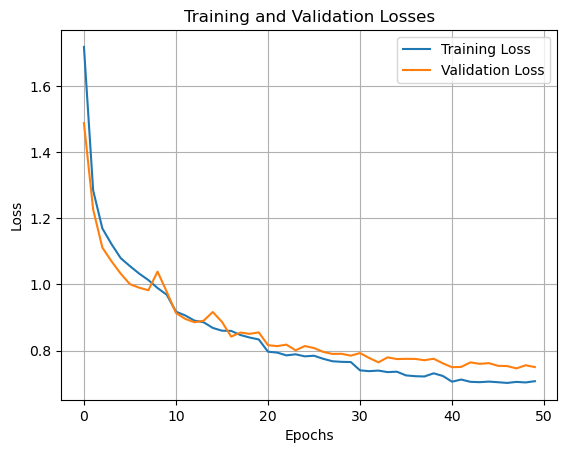

In [31]:
%matplotlib inline
plt.plot(train_combined_losses, label='Training Loss')
plt.plot(val_combined_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('Loss.png')
plt.show()

### Testing

In [18]:
model = UNet(n_channels=3, n_classes=8)
model.load_state_dict(torch.load('model_epoch_48.pth'))
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (transConv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, ke

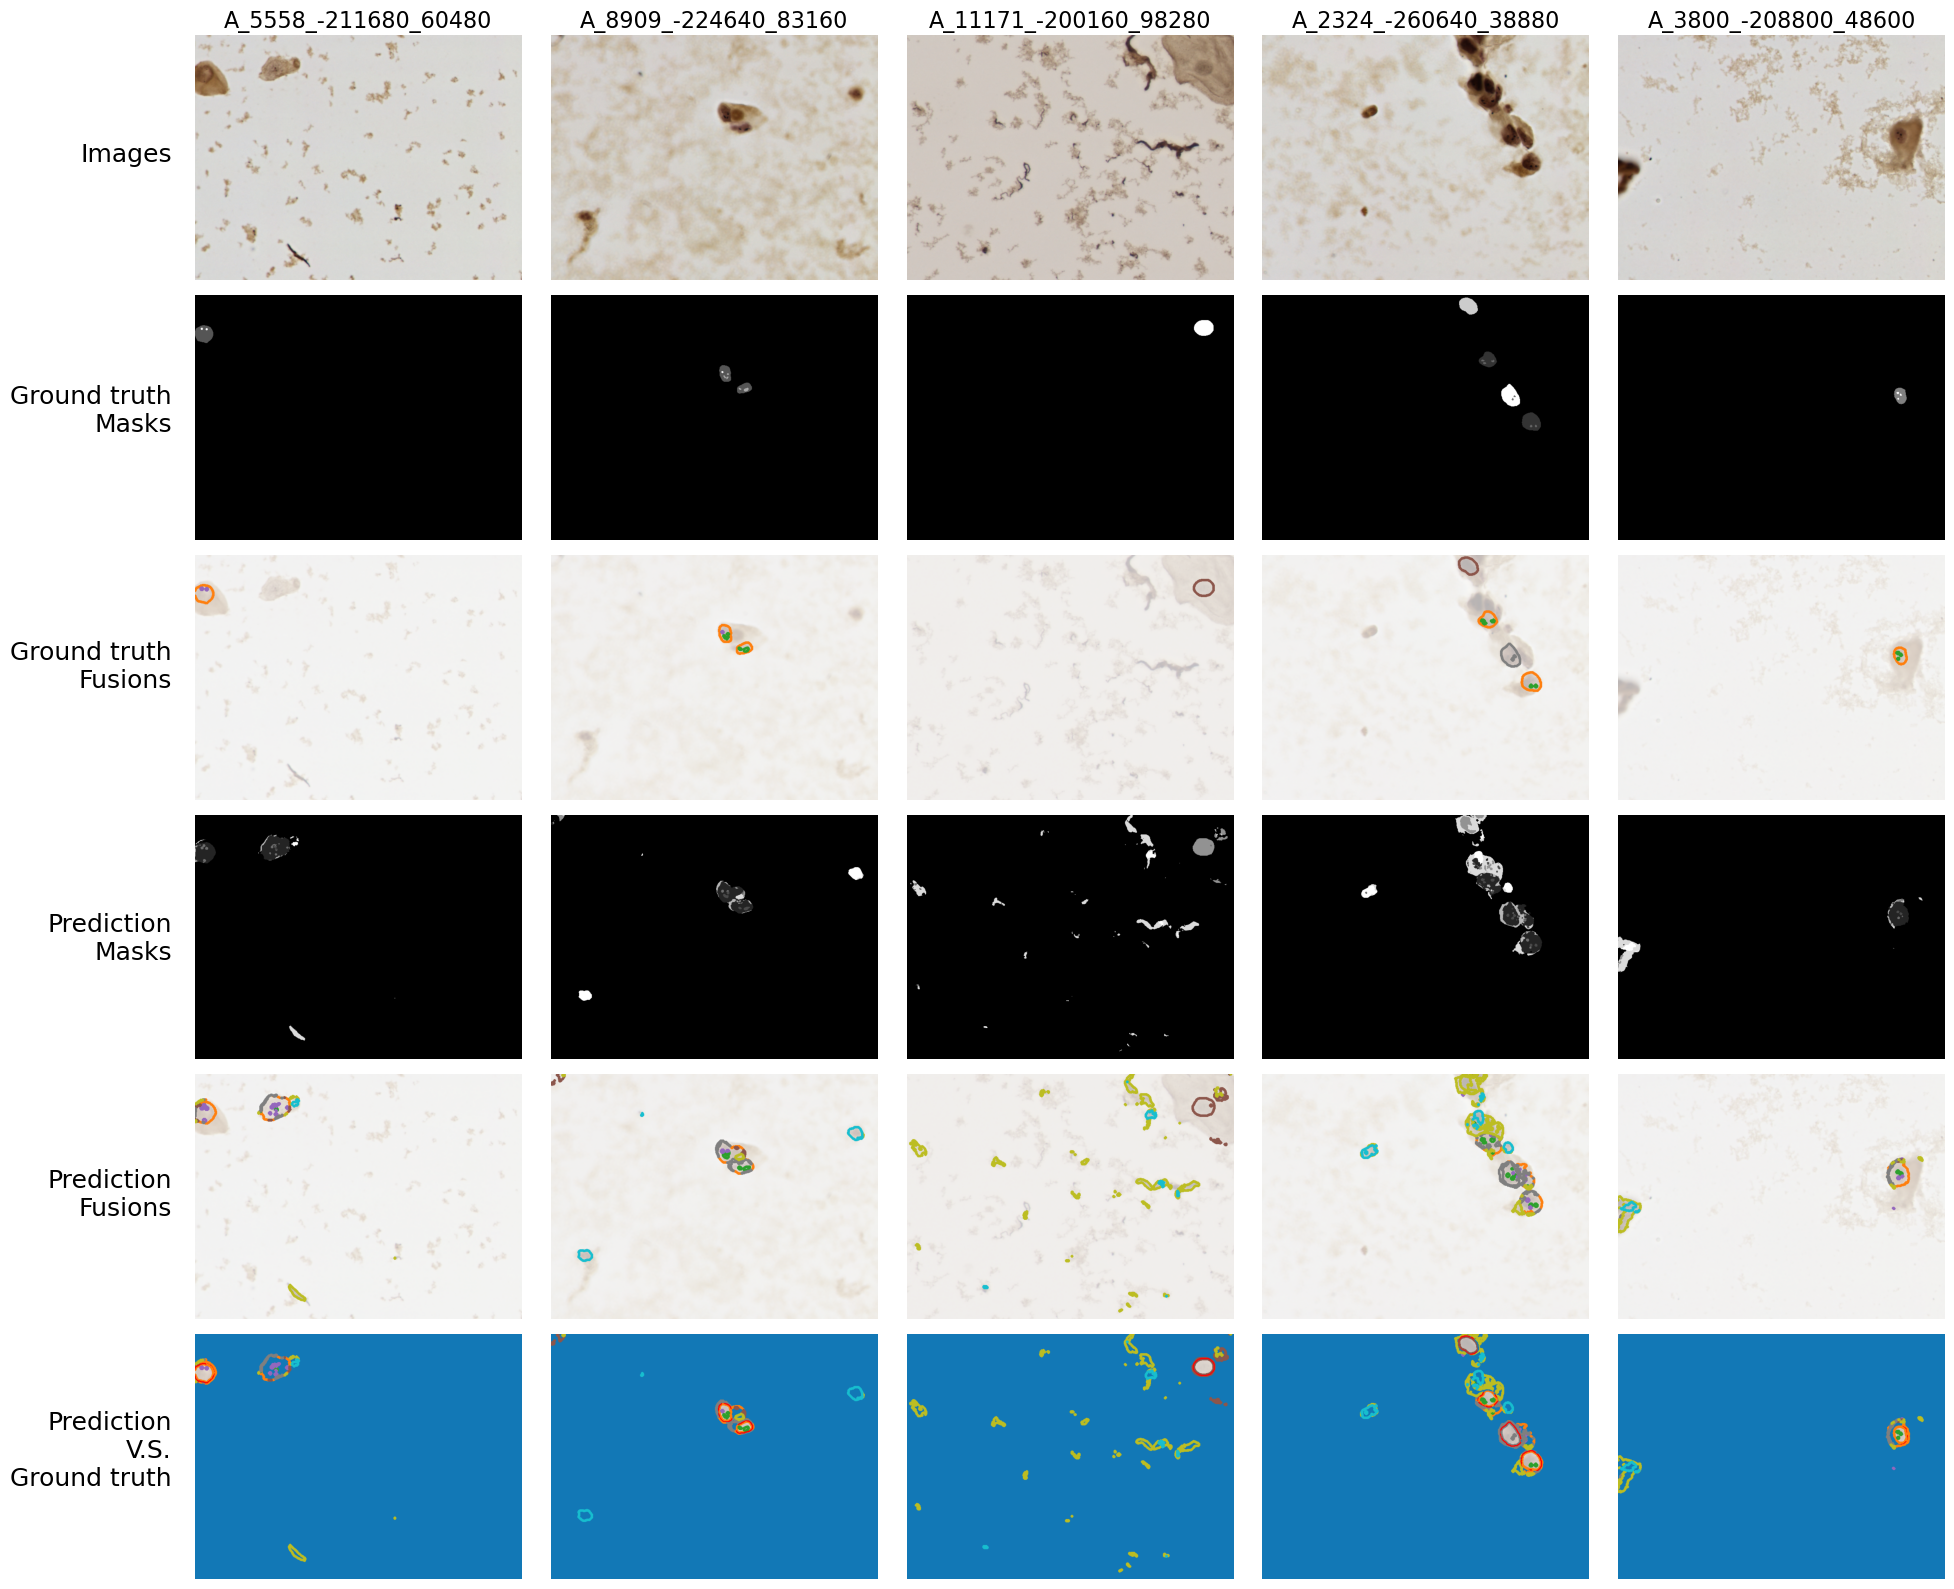

In [33]:
visualize_predictions(test_loader, dataset, model, device, mean, std, num_samples=5)

### Evaluation indicators

In [34]:
def pixelAccuracy(gen_mask, input_mask):
    pixel_labeled = torch.sum(input_mask > 0).float()
    pixel_corr = torch.sum((gen_mask == input_mask) * (input_mask > 0)).float()
    pixel_acc = pixel_corr / (pixel_labeled + 1e-10)

    return pixel_acc, pixel_corr, pixel_labeled

def intersectionAndUnion(gen_mask, input_mask, numClass=8):
    gen_mask = gen_mask * (input_mask > 0).long()
    intersection = gen_mask * (gen_mask == input_mask).long()
    (area_intersection, _) = np.histogram(intersection, bins=numClass, range=(1, numClass))

    (area_pred, _) = np.histogram(gen_mask, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(input_mask, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection

    IoU = area_intersection / (area_union + 1e-10)

    return IoU, area_intersection, area_union

def mIoU(gen_mask, input_mask):
    area_intersection = []
    area_union = []

    for i in range(input_mask.shape[0]):
        _, intersection, union = intersectionAndUnion(gen_mask[i], input_mask[i])
        area_intersection.append(intersection)
        area_union.append(union)

    IoU = 1.0 * np.sum(area_intersection, axis=0) / np.sum(np.spacing(1)+area_union, axis=0)

    return np.mean(IoU)

EPS = 1e-10
def nanmean(x):
    return torch.mean(x[x == x])

def _fast_hist(true, pred, num_classes):
    true = true.squeeze(1)
    pred = pred.squeeze(1)
    mask = (true >= 0) & (true < num_classes)
    hist = torch.bincount(
        num_classes * true[mask].long() + pred[mask].long(),
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist

def per_class_pixel_accuracy(hist):
    correct_per_class = torch.diag(hist)
    total_per_class = hist.sum(dim=1)
    per_class_acc = correct_per_class / (total_per_class + EPS)
    avg_per_class_acc = nanmean(per_class_acc)
    return avg_per_class_acc, per_class_acc

def per_class_PA (pred, label):
    hist = _fast_hist(pred, label,8)
    avg, per = per_class_pixel_accuracy(hist)
    return avg, per

def all_metrics(gen_mask, input_mask, model, dataloader, device, num_classes):
    pred_masks_max = gen_mask.argmax(dim=1)

    pred_masks_max_cpu = pred_masks_max.cpu()
    input_mask_cpu = input_mask.cpu()

    acc, cor, lab = pixelAccuracy(pred_masks_max_cpu, input_mask_cpu)
    acc = acc.item()
    
    IOU, _, _ = intersectionAndUnion(pred_masks_max_cpu, input_mask_cpu)
    MIOU = mIoU(pred_masks_max_cpu, input_mask_cpu)
    
    avg, per = per_class_PA(pred_masks_max_cpu, input_mask_cpu)
    DICE = multiclass_dice_coeff(pred_masks_max_cpu, input_mask_cpu)
    DICE = DICE.item()
    
    return acc, IOU, MIOU, avg, per, DICE

In [35]:
total_acc = 0
total_IOU = 0
total_MIOU = 0
total_avg = 0
total_per = []
total_DICE = 0
total_batches = 0

model.eval()
with torch.no_grad():
    for images, true_masks in test_loader:
        images = images.to(device)
        true_masks = true_masks.to(device).squeeze(1)

        outputs = model(images)

        acc, IOU, MIOU, avg, per, DICE = all_metrics(outputs, true_masks, model, test_loader, device, num_classes=8)
        
        total_acc += acc
        total_IOU += IOU
        total_MIOU += MIOU
        total_avg += avg
        total_per.append(per)
        total_DICE += DICE
        total_batches += 1

avg_acc = total_acc / total_batches
avg_IOU = total_IOU / total_batches
avg_MIOU = total_MIOU / total_batches
avg_avg = total_avg / total_batches
avg_DICE = total_DICE / total_batches

total_per_numpy = [per.numpy() for per in total_per]
stacked_per = np.stack(total_per_numpy, axis=0)
avg_per = np.mean(stacked_per, axis=0)

In [32]:
print("Average Pixel Accuracy (PA):", avg_acc)
print("Average Dice coefficient (Dice):", avg_DICE)
print("Average Intersection over Union (IoU):", avg_IOU)
print("Average mean Intersection over Union (mIoU):", avg_MIOU)

Average Pixel Accuracy (PA): 0.6300892986078314
Average Dice coefficient (Dice): 0.8901261658400776
Average Intersection over Union (IoU): [0.5488911  0.41240227 0.13520661 0.49806082 0.13858986 0.0966894
 0.4069296  0.0187284 ]
Average mean Intersection over Union (mIoU): 0.2795962060096852


In [27]:
def cPixelAccuracy(gen_mask, input_mask):    
    pixel_acc = np.empty(8)
    for i in range(8):
        pixel_corr = torch.sum((gen_mask == i) * (input_mask == i)).float()
        pixel_total = torch.sum((gen_mask == i) | (input_mask == i)).float()
        pixel_acc[i] = pixel_corr / (pixel_total + 1e-10)
    return pixel_acc

def all_metrics(gen_mask, input_mask):
    pred_masks_max = gen_mask.argmax(dim=1)

    pred_masks_max_cpu = pred_masks_max.cpu()
    input_mask_cpu = input_mask.cpu()
    
    return cPixelAccuracy(pred_masks_max_cpu, input_mask_cpu)

In [28]:
total_cPA = np.zeros(8)
total_batches = 0

model.eval()
with torch.no_grad():
    for images, true_masks in test_loader:
        images = images.to(device)
        true_masks = true_masks.to(device).squeeze(1)

        outputs = model(images)
        cPA = all_metrics(outputs, true_masks)

        total_cPA += cPA
        total_batches += 1

avg_cPA = total_cPA / total_batches
print(f"Average Class Pixel Accuracy (cPA): {avg_cPA}")

Average Class Pixel Accuracy (cPA): [0.97982688 0.34833545 0.26094218 0.07724198 0.20608071 0.06542377
 0.01108893 0.06208683]


In [31]:
mPA = np.nanmean(avg_cPA)
print(f"Mean Pixel Accuracy (mPA): {mPA*100}%")

Mean Pixel Accuracy (mPA): 25.137834138145738%


In [39]:
def compute_precision_recall(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return precision, recall

def compute_ap(precision, recall):
    return auc(recall, precision)

def compute_class_ap(model, dataloader, device, class_id):
    all_true_labels = []
    all_pred_scores = []

    for images, true_masks in dataloader:
        images = images.to(device)
        true_masks = true_masks.to(device)

        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        class_probabilities = probabilities[:, class_id, :, :].reshape(-1)

        class_true = (true_masks == class_id).reshape(-1).cpu().numpy()
        class_probabilities = class_probabilities.cpu().numpy()

        all_true_labels.extend(class_true)
        all_pred_scores.extend(class_probabilities)

    precision, recall, _ = precision_recall_curve(all_true_labels, all_pred_scores)
    ap = compute_ap(recall, precision)

    return ap

def compute_map(model, dataloader, device, num_classes):
    model.eval()
    aps = []

    with torch.no_grad():
        for class_id in range(num_classes):
            ap = compute_class_ap(model, dataloader, device, class_id)
            aps.append(ap)

    return np.mean(aps)

In [ ]:
mAP = compute_map(model, test_loader, device, num_classes=8)
print("mAP:", mAP)